The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


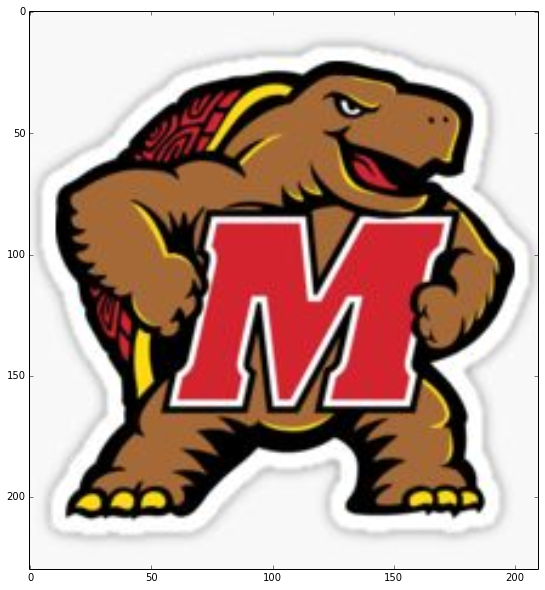

time: 580 ms


In [103]:
%matplotlib inline
%load_ext autotime
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

img = cv2.imread('testudo.jpg', 1)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_rgb)

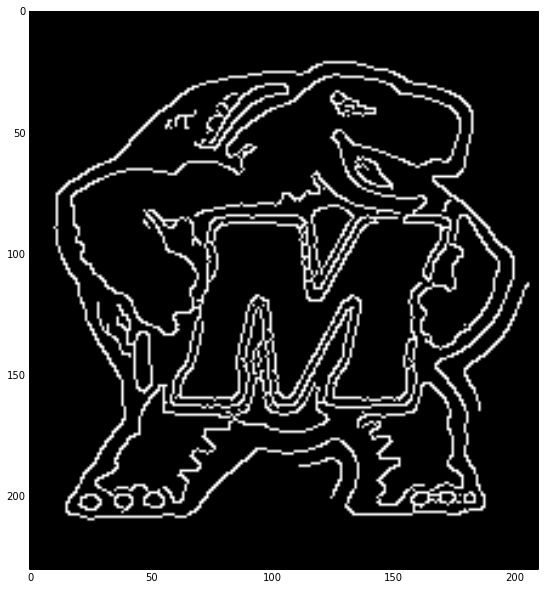

time: 367 ms


In [104]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.medianBlur(gray, 5)
v = np.median(blurred)
sigma = 0.6
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
edges = cv2.Canny(blurred, 100, 200).astype(bool)

# edges = edges[:300, 0:300]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(edges, cmap='gray')  

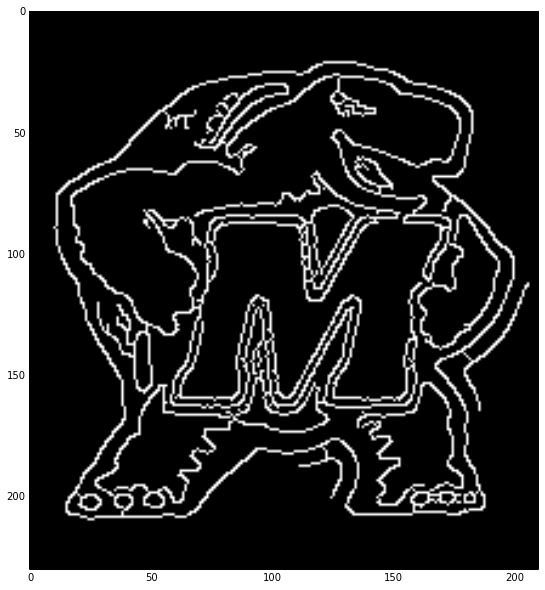

time: 1.06 s


In [105]:
import heapq
from itertools import *
import sys
import time
import random
m, n = edges.shape
sys.setrecursionlimit(n*m)

def inbounds(img, i, j):
    m, n = img.shape
    proposal = [(i+1, j), (i-1, j), (i+1, j+1), (i+1, j-1), (i-1, j+1), (i-1, j-1), (i, j+1), (i, j-1)]
    return ((k, l) for (k, l) in proposal if 0 <= k < m and 0 <= l < n)
    
def neighbors(img, i, j):
    m, n = img.shape
    proposal = [(i+1, j), (i-1, j), (i+1, j+1), (i+1, j-1), (i-1, j+1), (i-1, j-1), (i, j+1), (i, j-1)]
    return ((k, l) for (k, l) in proposal if 0 <= k < m and 0 <= l < n and img[k, l])
    
def find_component(img, i, j, result, unconnected):
    m, n = img.shape
    result.add((i, j))
    if (i, j) in unconnected: unconnected.remove((i, j))
    for (k, l) in neighbors(img, i, j):
        if (k, l) in result: continue
        find_component(img, k, l, result, unconnected)
        
def reconstruct((i, j), came_from, result):
    connection = set()
    while (i, j) in came_from.keys():
        i, j = came_from[(i, j)]
        result[i, j] = True
        connection.add((i, j))
    return connection

def connect_component(img, component, unconnected, target):
    heuristic = lambda p1, p2: (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2
    queue = []
    gscore = np.zeros_like(img) + float('inf')
    fscore = np.zeros_like(img) + float('inf')
    for index in component:
        gscore[index] = 0
        fscore[index] = heuristic(index, target)
        heapq.heappush(queue, (fscore[index], index))
    came_from = {}
    while True:
        if len(queue) == 0:
            return None, None
        cost, (i, j) = heapq.heappop(queue)
        if (i, j) in unconnected:
            break
        for (k, l) in inbounds(img, i, j):
            new_g = cost + (1 if i == k or j == l else 1.414)
            if new_g < gscore[k, l]:
                gscore[k, l] = new_g
                fscore[k, l] = new_g + heuristic((k, l), target)
                heapq.heappush(queue, (fscore[k, l], (k, l)))
                came_from[(k, l)] = (i, j)
    connection = reconstruct((i, j), came_from, img)
    return (i, j), connection
        
def find_components(img):
    result = np.zeros_like(img).astype(bool)
    queue = []
    gscore = np.zeros_like(img) + float('inf')
    i, j = np.argwhere(edges)[0]
    n = np.sum(img)
    unconnected = set((k, l) for k, l in np.argwhere(img))
    components = []
    while len(unconnected) > 0:
        component = set()
        find_component(img, i, j, component, unconnected)
        components.append(component)
        if len(unconnected ) > 0:
            i, j = unconnected.pop()
#         i, j = connect_component(img, component, unconnected)
    return components

def sample(component):
    n = len(component)
    size = max(int(n / 4), 1)
    component = np.array(list(component))
    i = np.random.choice(np.arange(n), size=size, replace=False)
    return component[i]

def connect(img, components):
    components = components
    samples = [sample(component) for component in components]
    unconnected = set((k, l) for k, l in np.argwhere(img))
    giant_component = set()
    component = components.pop(0)
    points = samples.pop(0)
    while len(components) > 0:
        giant_component = giant_component | component
        for (j, l) in component:
            unconnected.remove((j, l))
        
        giant_approx = sample(giant_component)
        best_dist = float('inf')
        best_point = None
        for c in components:
            approx = sample(c)
            for point in approx:
                dists = np.sum(np.square(giant_approx - point), 1)
                l = np.argmin(dists)
                if dists[l] < best_dist:
                    best_dist = dists[l]
                    best_point = point

        index, connection = connect_component(img, giant_component, unconnected, best_point)
        j = np.argwhere([index in c for c in components])
        component = components.pop(j)
        
        giant_component = giant_component | connection
    
    
connected_edges = np.copy(edges)
components = find_components(connected_edges)
connect(connected_edges, components)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(connected_edges, cmap='gray')  
        

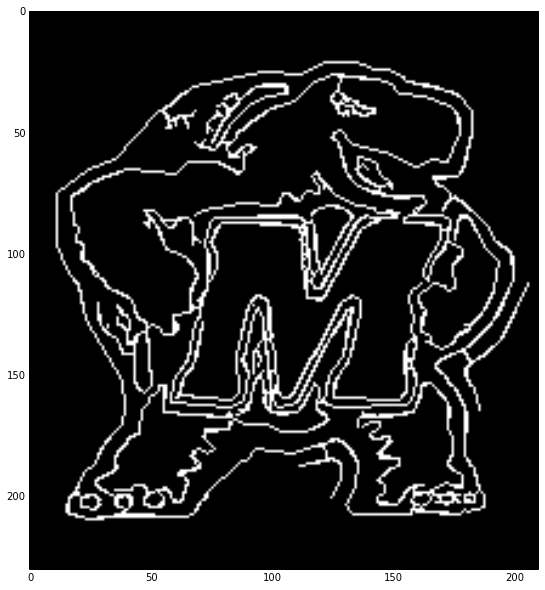

time: 446 ms


In [110]:
def find_contour(img, i, j, path, visited):
    m, n = img.shape
    path.append((j, i))
    visited.add((i, j))
    for (k, l) in neighbors(img, i, j):
        if (k, l) in visited: continue
        find_contour(img, k, l, path, visited)
        path.append((j, i))
    


# buf = connected_edges.astype('uint8')
# contours, _ = cv2.findContours(buf, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
# approx_contours = None
# size = 0
# for contour in contours:
#     length = cv2.arcLength(contour,True)
#     approx = np.squeeze(cv2.approxPolyDP(contour, 1, True))
#     if len(approx.shape) > 1 and approx.shape[0] > size:
#         approx_contours = approx
#         size = approx.shape[0]



(i, j) = np.argwhere(connected_edges)[0]
approx_contours =  []
find_contour(connected_edges, i, j, approx_contours, set())
approx_contours = np.array(approx_contours)

approx = np.squeeze(cv2.approxPolyDP(approx_contours, 1, True))
    
approx_img = np.zeros_like(connected_edges).astype('uint8')
cv2.drawContours(approx_img, [approx], -1, 255, 1)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(approx_img, cmap='gray')  

In [95]:
import pickle
m, n = connected_edges.shape
with open('points', 'w') as f:
    pickle.dump((approx, m, n), f)

time: 5.61 ms


In [112]:
# 6.286" 1376
# 218.89914
# 5.75 x 4 -> 5.25 x 3.50
# 1150 x 875


time: 962 µs


In [8]:
sys.argv


['/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py',
 '-f',
 '/run/user/1000/jupyter/kernel-b33bee82-04ad-4061-a1c2-0d97dce8e4f2.json']

time: 2.67 ms


In [111]:
approx.shape

(1168, 2)

time: 2.61 ms
